In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read Dataset

In [70]:
df = pd.read_csv('/content/train.csv').rename(columns={'sms':'text'})

In [71]:
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [72]:
red_palette = sns.color_palette("Reds_r", 2)
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

Data Visualization

Label Distribution and Text Length Distribution Plot

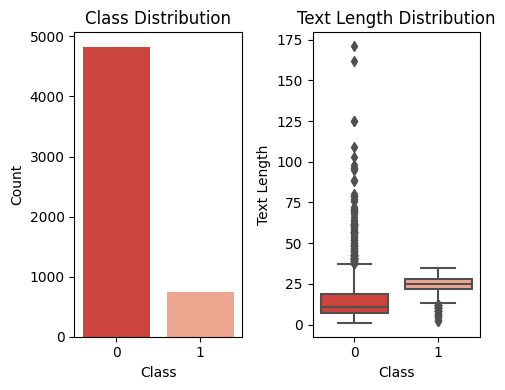

In [73]:
plt.figure(figsize=(5, 4), dpi=100)
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

Text Length Distribution with KDE

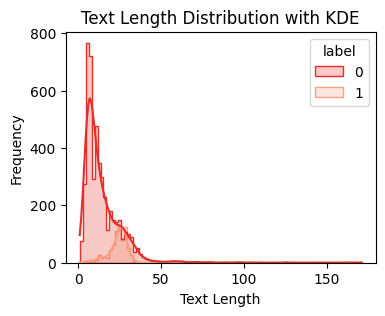

In [74]:
plt.figure(figsize=(4, 3), dpi=100)
sns.set_palette(red_palette)
sns.histplot(data=df, x='text_length', hue='label', kde=True, element='step')
plt.title('Text Length Distribution with KDE')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

Word Cloud for two labels

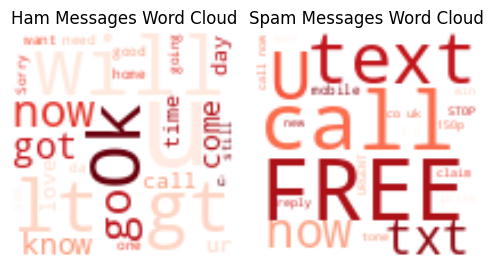

In [75]:
ham_text = " ".join(df[df['label'] == 0]['text'])
spam_text = " ".join(df[df['label'] == 1]['text'])

ham_wordcloud = WordCloud(width=100, height=100, background_color='white', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=100, height=100, background_color='white', colormap=red_palette_c).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(5, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

Text Preprocessing and Modeling

In [76]:
def preprocess_text(text):
    words = word_tokenize(text) #Tokenization
    words = [word.lower() for word in words if word.isalnum()] #to Lowercase
    words = [word for word in words if word not in stopwords.words("english")] #Remove Stopwords
    return " ".join(words) #Concate tokens

In [77]:
df['text'] = df['text'].apply(preprocess_text)

TF-IDF Vectorization and Multinomial Naive Bay

In [79]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['text']).toarray()
y = df['label']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
sklearn_classifier = MultinomialNB(alpha=.1) #alpha=0.1 is more accurate for our model
sklearn_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

SklearnNLTKClassifier Class:

In [82]:
class SklearnNLTKClassifier(nltk.classify.ClassifierI): #Constructor
    def __init__(self, classifier):
        self._classifier = classifier

    def classify(self, features): #Predict for one feature
        return self._classifier.predict([features])[0]

    def classify_many(self, featuresets): #Predict for multiple features
        return self._classifier.predict(featuresets)

    def prob_classify(self, features): #Shows error for not implementating
        raise NotImplementedError("Probability estimation not available.")

    def labels(self): #return labels
        return self._classifier.classes

In [83]:
nltk_classifier = SklearnNLTKClassifier(sklearn_classifier)


Prediction for test data

In [84]:
y_pred = nltk_classifier.classify_many(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
acc = f"Accuracy is : {accuracy:.2f}"

Classification Report

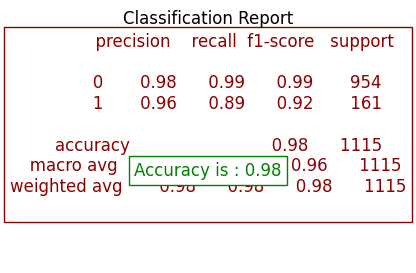

In [86]:
plt.figure(figsize=(4, 3), dpi=100)
plt.text(0.5, 0.6, report, fontsize=12, color='darkred', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='darkred'))
plt.text(0.5, 0.4, acc, fontsize=12, color='Green', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='green'))
plt.title('Classification Report')
plt.axis('off')
plt.show()

confusion matrix¶

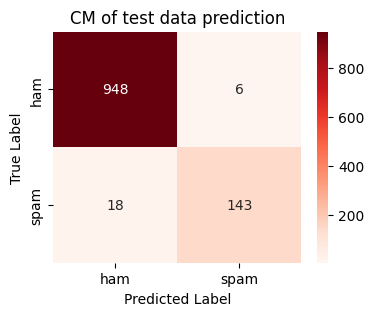

In [87]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3), dpi=100)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()